In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

# Autoencoder

In [27]:
def autoencoder(data, streaming=np.array([0]), reduction=9, epochs=200, batch_size=32):
    L, W = data.shape
    
    visible = Input(shape=(W,))
    e = Dense(W*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    e = Dense(W)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    n_bottleneck = round(reduction)
    bottleneck = Dense(n_bottleneck)(e)

    d = Dense(W)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Dense(W*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    output = Dense(W, activation='linear')(d)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(data, data, epochs=epochs, batch_size=batch_size, verbose=0)
    encoder = Model(inputs=visible, outputs=bottleneck)
    
    if streaming.any():
        reconstructed_data = model.predict(data)
        RMSE = (np.sum((data-reconstructed_data)**2,axis=1)/W)**.5
        encoded_data = encoder.predict(data)
        encoded_data = np.concatenate((encoded_data, RMSE.reshape(-1,1)), axis=1)
        
        reconstructed_streaming = model.predict(streaming)
        RMSE = (np.sum((streaming-reconstructed_streaming)**2,axis=1)/W)**.5
        encoded_streaming = encoder.predict(streaming)
        encoded_streaming = np.concatenate((encoded_streaming, RMSE.reshape(-1,1)), axis=1)
        return encoded_data, encoded_streaming
    else:
        reconstructed_data = model.predict(data)

        RMSE = (np.sum((data-reconstructed_data)**2,axis=1)/W)**.5

        encoded_data = encoder.predict(data)

        encoded_data = np.concatenate((encoded_data, RMSE.reshape(-1,1)), axis=1)
        
        return encoded_data

# Distribuições

In [3]:
def distribution (data, suptitle, b_sep, streaming=np.array([0])):
    L, W = data.shape
    rows = 2
    L2 = 0
       
    if streaming.any():
        b_sep = L + b_sep
        rows = 3
        data = np.concatenate((data,streaming))
        
    color = ['tab:blue', 'tab:orange']
    titles = [' - Var {}'.format(i) for i in range(1,W)] + [' - RMSE']
    
    f, ax = plt.subplots(nrows=rows, ncols=W, figsize=(W*8,rows*8), sharex='col', constrained_layout=True)
    plt.suptitle(suptitle, fontsize=50)
    for i in range(W):
        ax[0,i].hist(data[:b_sep,i], bins=400, color=color[0], density=True)
        ax[0,i].set_title('Background{}'.format(titles[i]), fontsize=30)
        
        if streaming.any():
            ax[1,i].hist(data[L:b_sep,i], bins=400, color=color[0], density=True)
            ax[1,i].set_title('Streaming Background{}'.format(titles[i]), fontsize=30)
        
        ax[-1,i].hist(data[b_sep:,i], color=color[1], density=True)
        ax[-1,i].set_title('Signal{}'.format(titles[i]), fontsize=30)
    
    plt.show()
    return f

# Incialização

In [4]:
if __name__ == '__main__':
    ##########################################################
    # ------------------------------------------------------ #
    # --------------------- INITIATION --------------------- #
    # ------------------------------------------------------ #
    ##########################################################
    ### Define User Variables ###
    # Number of events
    total = 10000

    # Percentage of background samples on the testing phase
    background_percent = 0.99

    # Percentage of samples on the training phase
    test_size = 0.3

In [5]:
if __name__ == '__main__':
    ##########################################################
    # ------------------------------------------------------ #
    # ----------------------- LOADING ---------------------- #
    # ------------------------------------------------------ #
    ##########################################################
    # Firstly the model loads the background and signal data, 
    # then it removes the attributes first string line, which 
    # are the column names, in order to avoid NaN values in 
    # the array.
    print('         ==== Commencing Initiation ====\n')

    ### Background    
    b_name='Input_Background_1.csv'
    background = np.genfromtxt(b_name, delimiter=',')
    background = background[1:,:]
    Lb, W = background.shape
    print("     .Background Loaded..." )
    print("     .Background shape: {}".format(background.shape))

    ### Signal
    s_name='Input_Signal_1.csv'
    signal = np.genfromtxt(s_name, delimiter=',')
    signal = signal[1:,:]
    Ls, _ = signal.shape
    print("     .Signal Loaded...")
    print("     .Signal shape: {}\n".format(signal.shape))

    print('\n          ==== Initiation Complete ====\n')
    print('=*='*17 )
    print('      ==== Commencing Data Processing ====')

         ==== Commencing Initiation ====

     .Background Loaded...
     .Background shape: (543500, 21)
     .Signal Loaded...
     .Signal shape: (522467, 21)


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
      ==== Commencing Data Processing ====


# Totalmente não Supervisionado
 - 9900 of Background samples
 - 100 of Signal samples

In [6]:
if __name__ == '__main__':
    # Divide data-set into training and testing sub-sets
    print('         .Dividing training and testing sub-sets')
    b_test = int(total*background_percent)
    _, divided_background = train_test_split(background, test_size=b_test/Lb)

    # Defining number of events Signal events on online phase.
    signal_online_samples = int(total - b_test)
    _, reduced_signal = train_test_split(signal, test_size=signal_online_samples/Ls)

    print('         .Selecting Signal on the following porpotion:')
    print('             .{:9d} of Background samples (Online)'.format(int(b_test)) )
    print('             .{:9d} of Signal samples (Online)'.format(int(signal_online_samples)))

    # Concatenating Signal and the Test Background sub-set
    data_raw = np.concatenate((divided_background,reduced_signal), axis=0)
    print("             .Online shape: {}\n".format(data_raw.shape))

    # Normalize Data
    print('         .Normalizing Data')
    norm = MinMaxScaler().fit(data_raw)
    data = norm.transform(data_raw)

         .Dividing training and testing sub-sets
         .Selecting Signal on the following porpotion:
             .     9900 of Background samples (Online)
             .      100 of Signal samples (Online)
             .Online shape: (10000, 21)

         .Normalizing Data


In [25]:
encoded_data = autoencoder(data)

(10000, 10)

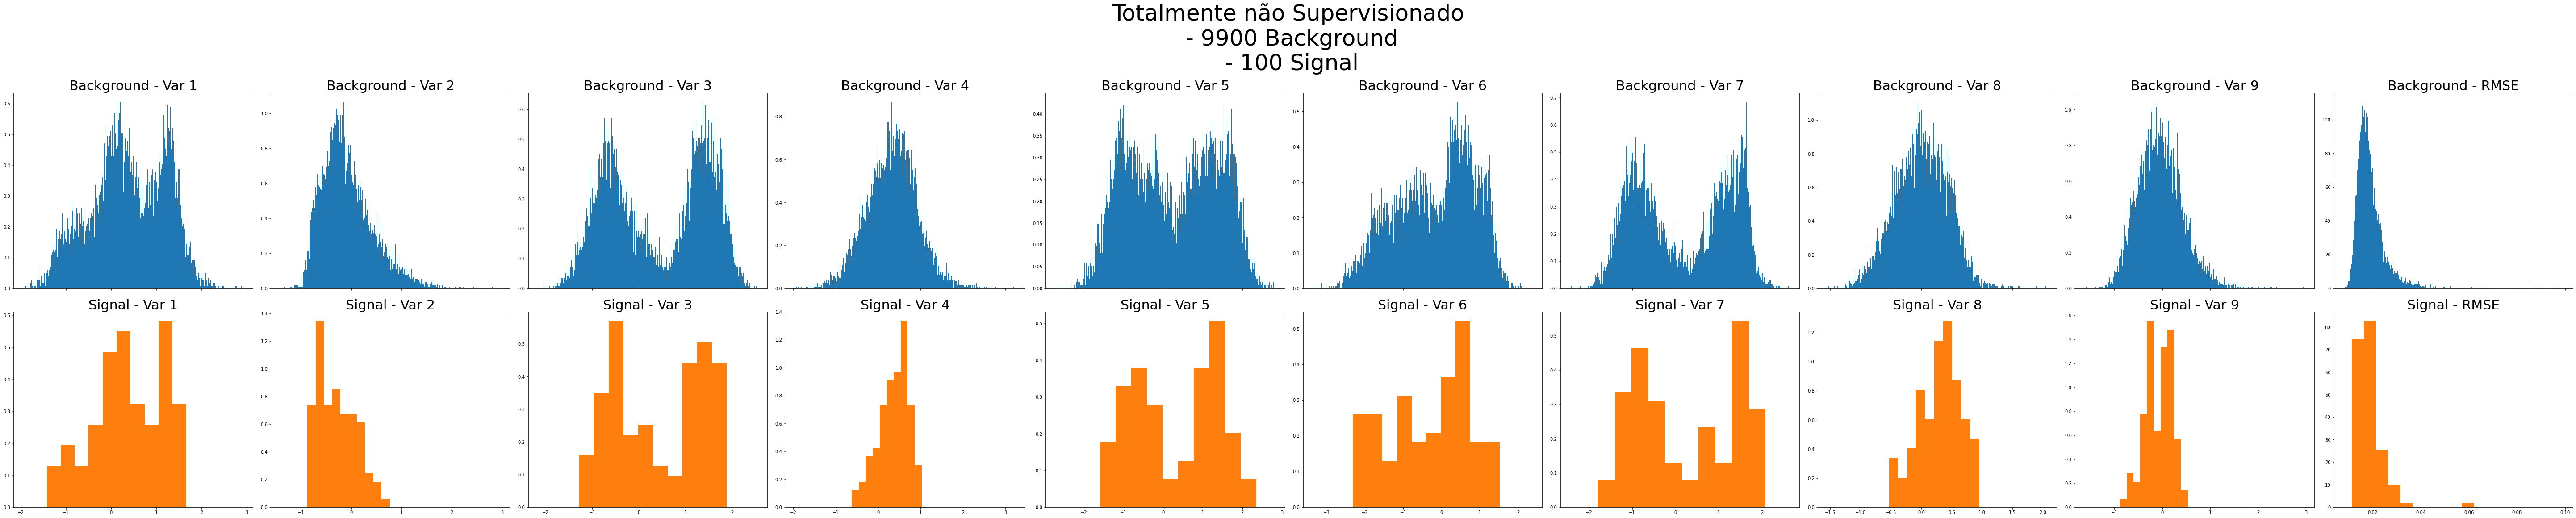

In [26]:
suptitle = 'Totalmente não Supervisionado\n - 9900 Background\n - 100 Signal'
fig1 = distribution(encoded_data, suptitle, b_test)

# Abordagem com Static e Streaming

 - 7000 of Background samples (Offline)
 - 2970 of Background samples (Online)
 - 30 of Signal samples (Online)

In [28]:
if __name__ == '__main__':
    # Divide data-set into training and testing sub-sets
    print('         .Dividing training and testing sub-sets')
    _, divided_background = train_test_split(background, test_size=total/Lb)

    test = int(total*test_size)
    b_test = int(test*background_percent)
    static_data_raw, background_test = train_test_split(divided_background, test_size=test_size, random_state=42)
    _, background_test = train_test_split(background_test, test_size=b_test/background_test.shape[0])

    # Defining number of events Signal events on online phase.
    signal_online_samples = int(test - b_test)
    _, reduced_signal = train_test_split(signal, test_size=signal_online_samples/Ls)

    print('         .Selecting Signal on the following porpotion:')
    print('             .{}% Background samples'.format(int(background_percent*100)))
    print('             .{}% Signal samples'.format(int((1-background_percent)*100)))
    print('             .{:9d} of Background samples (Offline)'.format(int(total*(1-test_size))))
    print('             .{:9d} of Background samples (Online)'.format(int(b_test)) )
    print('             .{:9d} of Signal samples (Online)'.format(int(signal_online_samples)))

    # Concatenating Signal and the Test Background sub-set
    streaming_data_raw = np.concatenate((background_test,reduced_signal), axis=0)
    print("             .Offline shape: {}".format(static_data_raw.shape))
    print("             .Online shape: {}\n".format(streaming_data_raw.shape))

    # Normalize Data
    print('         .Normalizing Data')
    norm = MinMaxScaler().fit(static_data_raw)
    static = norm.transform(static_data_raw)
    streaming = norm.transform(streaming_data_raw)

         .Dividing training and testing sub-sets
         .Selecting Signal on the following porpotion:
             .99% Background samples
             .1% Signal samples
             .     7000 of Background samples (Offline)
             .     2970 of Background samples (Online)
             .       30 of Signal samples (Online)
             .Offline shape: (7000, 21)
             .Online shape: (3000, 21)

         .Normalizing Data


### Parte 1

Treinando o Autoencoder com os dados Static e Streaming concatenados

In [29]:
full_data = np.concatenate((static, streaming))


encoded_data1 = autoencoder(full_data)

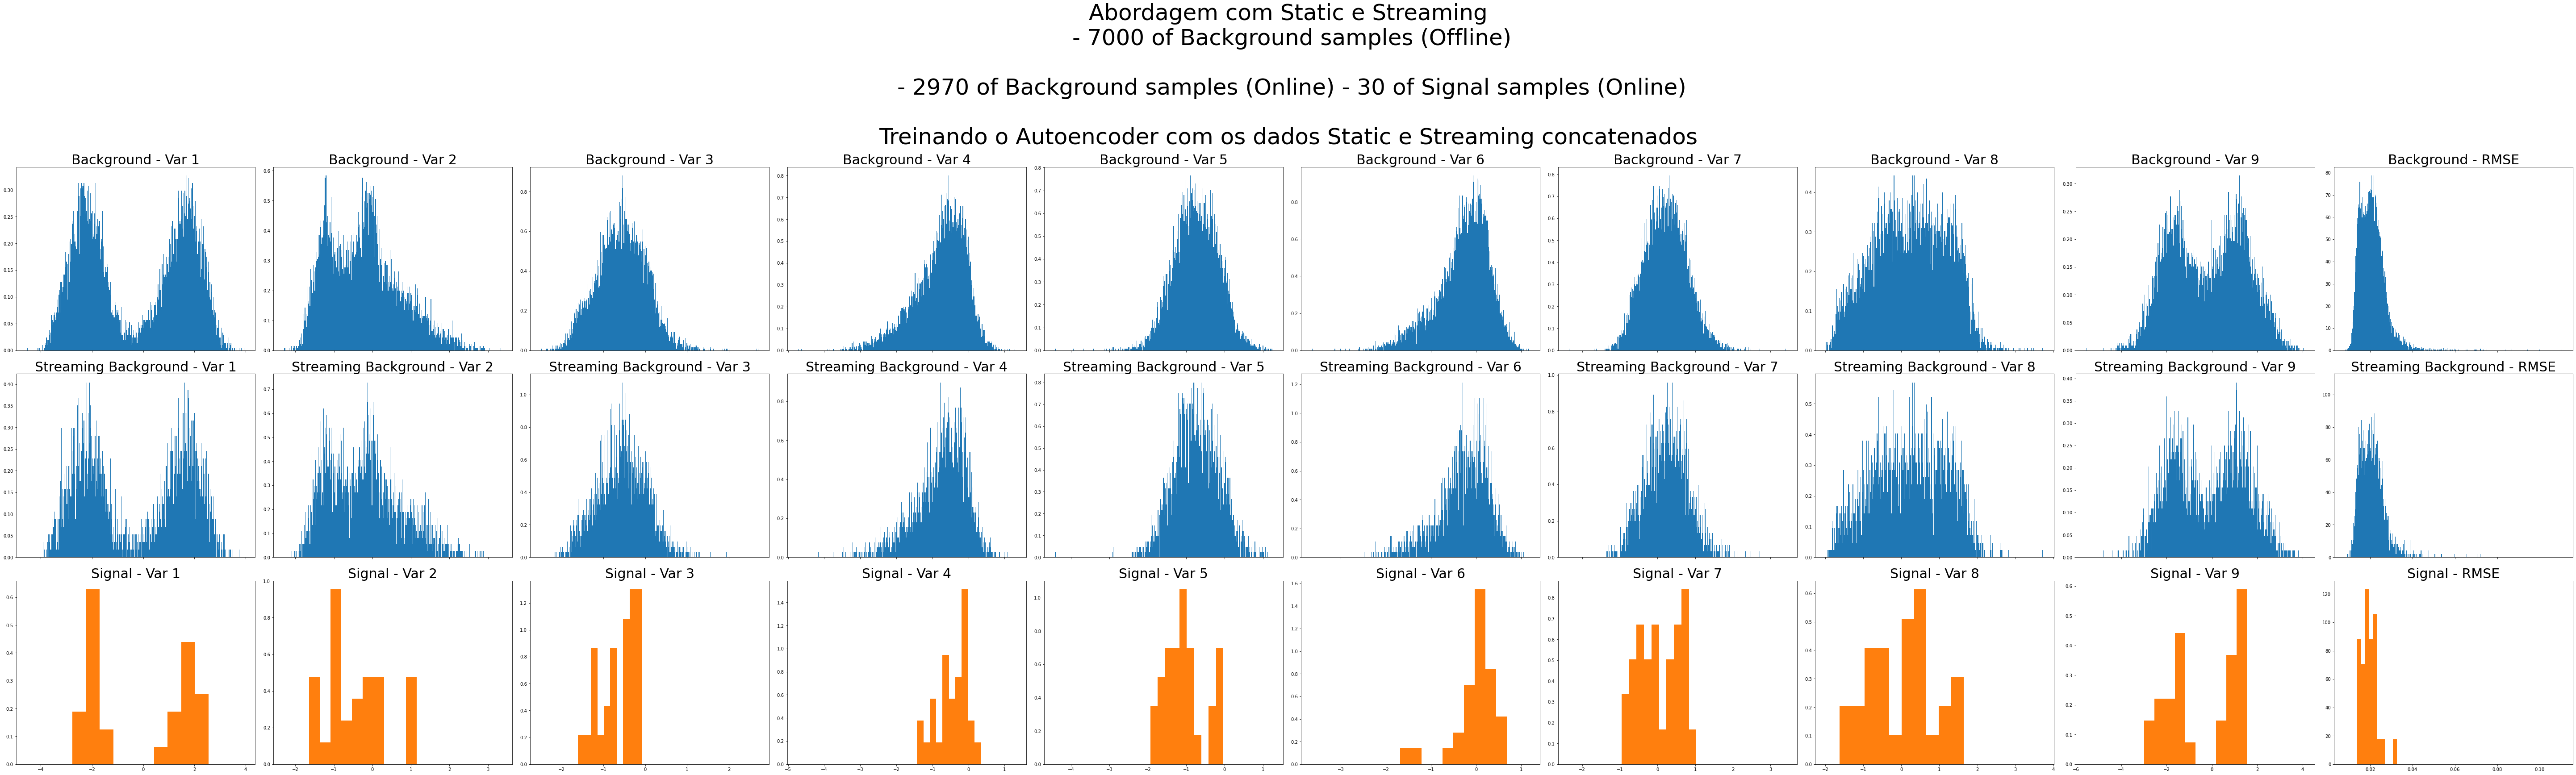

In [30]:
suptitle = '''Abordagem com Static e Streaming\n - 7000 of Background samples (Offline)\n
 - 2970 of Background samples (Online) - 30 of Signal samples (Online)\n\nTreinando o Autoencoder com os dados Static e Streaming concatenados'''

fig2 = distribution(encoded_data1[:total-test,:], suptitle, b_test, streaming=encoded_data1[total-test:,:])

### Parte 2

Treinando o Autoencoder somente com os dados Static

In [31]:
encoded_data2, encoded_streaming = autoencoder(static, streaming=streaming)

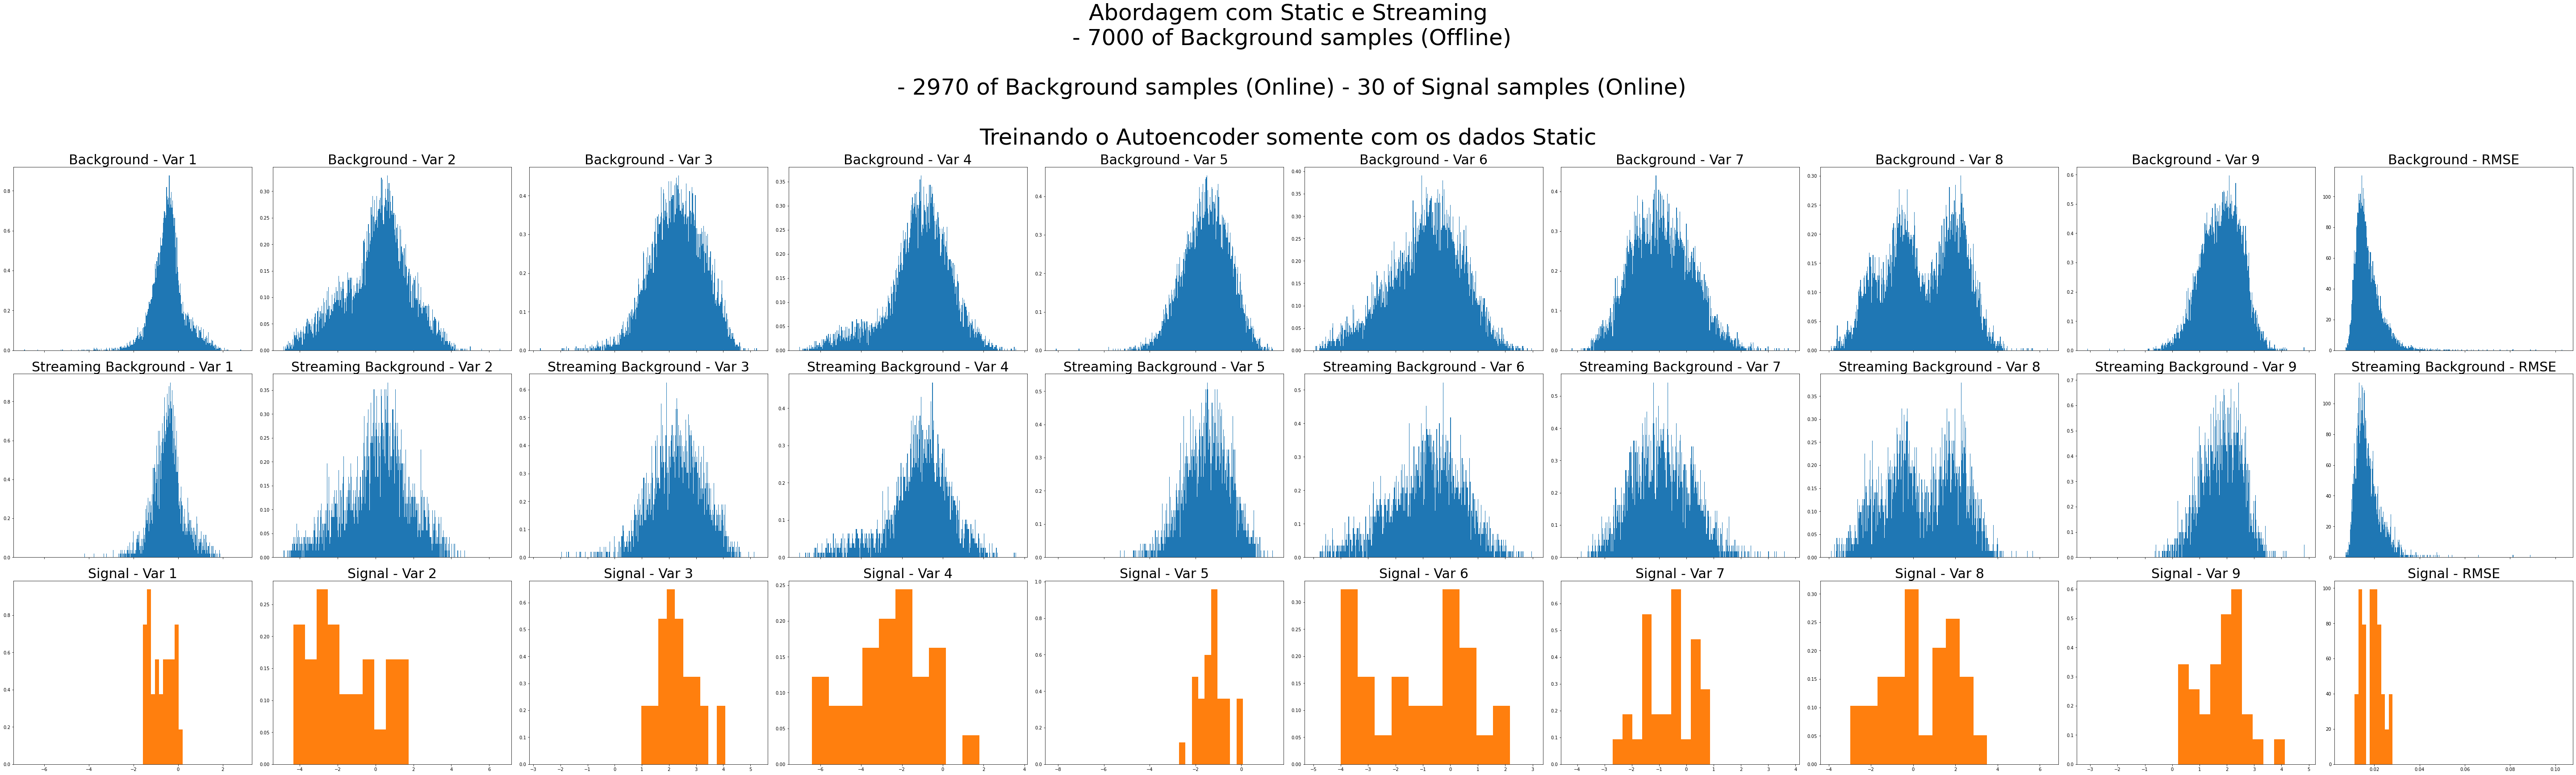

In [32]:
suptitle = '''Abordagem com Static e Streaming\n - 7000 of Background samples (Offline)\n
 - 2970 of Background samples (Online) - 30 of Signal samples (Online)\n\nTreinando o Autoencoder somente com os dados Static'''

fig3 = distribution(encoded_data2, suptitle, b_test, streaming=encoded_streaming)

In [33]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("distribution.pdf")
for fig in [fig1,fig2,fig3]:
    pdf.savefig( fig )
pdf.close()